In [1]:
from IPython.display import HTML 
s="""<h1>2D Poisson Equation</h1></br><div id="toc"></div>
<script src="https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js" defer></script>""";
h=HTML(s); h

***
# Understand the Problem

* What is the 2D pressure field for the **Poisson equation** when the initial conditions are **zero everywhere** and the boundary conditions are 0 and two source term spikes exists?

* The Poisson Equation for pressure is described as follows:

$$ {\partial^2 p \over \partial x^2} + {\partial^2 p \over \partial y^2} = b $$

***

# Formulate the Problem

## Input Data:

This problem has **no temporal component**, so we use a number of iterations.

* `niter` = 51 (maximum number of iterations)
* `nx` = 21 (number of x spatial points)
* `ny` = 11 (number of y spatial points)
* `xmax` = 2
* `ymax` = 1

## Initial Conditions:

* $\forall (n, x, y) \quad n = 0 \rightarrow p = 0$

## Boundary Conditions:

* $\forall (n, x, y) \quad x = 0 \lor x = 2 \lor y = 0 \lor y = 1  \rightarrow p = 0$

## Source Term

* $\forall (n, i, j) \quad {i = {{nx} \over 4}} \lor {j = {{ny} \over 4}} \rightarrow b_{i,j}=100 $
* $\forall (n, i, j) \quad {i = {{3nx} \over 4}} \lor {j = {{3ny} \over 4}} \rightarrow b_{i,j}=-100 $
* $\forall (n, i, j) \quad \lnot \left( {i = {{3nx} \over 4}} \lor {j = {{3nj} \over 4}} \lor {i = {{3nx} \over 4}} \lor {j = {{3nj} \over 4}} \right ) \rightarrow b_{i,j}=0 $

## Output Data:

* $\forall (n,x,y) \quad \ p = ?$

***

# Design Algorithm to Solve Problem

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* j $\rightarrow$ index of grid in y
* n $\rightarrow$ index of iterations

## Numerical scheme
* 1st order FD in time (actually a number of iterations)
* 2nd order CD in space

## Discrete equation

Since no terms have a temporal component - bring source term to other side and equate to forward differencing (as we did for Laplace Equation). Then take steady state after a certain number of iterations.

$$ {{\partial p} \over {\partial t}} = {\partial^2 p \over \partial x^2} + {\partial^2 p \over \partial y^2} - b $$

$$ {{p_{i,j}^{n+1}-p_{i,j}^n} \over {\Delta t}} = {{p_{i+1,j}^n -2p_{i,j}^n + p_{i-1,j}^n} \over \Delta x^2} + {{p_{i,j+1}^n -2p_{i,j}^n + p_{i,j-1}^n} \over \Delta y^2} - b_{i,j}^n $$

Also assume that $ \Delta x = \Delta y = h $

$$ {{p_{i,j}^{n+1}-p_{i,j}^n} \over {\Delta t}} = {{p_{i+1,j}^n -2p_{i,j}^n + p_{i-1,j}^n} \over h^2} + {{p_{i,j+1}^n -2p_{i,j}^n + p_{i,j-1}^n} \over h^2} - b_{i,j}^n $$


## Transpose

$$ p_{i,j}^{n+1} = p_{i,j}^n + {{\Delta t} \over {h^2}} \left( 
p_{i+1,j}^n + p_{i-1,j}^n + p_{i,j+1}^n + p_{i,j-1}^n - 4p_{i,j}^n \right) - b_{i,j}^n \Delta t $$

For the fastest convergence $ r = {{\Delta t} \over {h^2}} = {1 \over 4} $ and $ \Delta t = {{h^2} \over 4} $

Hence:

$$ p_{i,j}^{n+1} = {1 \over 4} \left( p_{i+1,j}^n + p_{i-1,j}^n + p_{i,j+1}^n + p_{i,j-1}^n - b_{i,j}^n h^2 \right) $$

## Pseudo-code

    niter = 500 
    nx =  21
    xmax = 2
    ny = 11
    ymax = 1
    dx = xmax/(nx-1)
    dy = ymax/(ny-1)
    error_target = 1*10^-2

    # Dirichlet Boundary Conditions

        p(0,:,:) = p(nx-1,:,:) = p(:,0,:) = p(:,nj-1,:) = 0
   
    # Initial Conditions
    
        p(:,:,0) = 0
   
    # Numerical Computation

    while error GT error_target:

    for n between 0 and niter-2
      for i between 1 and nx-2
        for j between 1 and ny-2
        
           if(i == (nx / 4) OR j == (ny / 4))
              b(i,j,n) = 100
           else if (i == (3nx / 4) OR j == (3ny / 4))
              b(i,j,n) = -100
           else
              b(i,j,n) = 0
              
           p(i,j,n+1) = p(i+1,j,n) + p(i-1,j,n) + p(i,j+1,n) + p(i,j-1,n) - b(i,j,n) * (h**2)/4
           
           error = sum[abs(p(i,j,n+1)) - abs(p(i,j,n)) ] / sum[abs(p(i,j,n))]
           
***

# Implement algorithm in Python

I initially tried this with the laplace equation from the previous case

In [1]:
def laplace_equation(error_target, niter, nx, xmax, ymax):

    """
    Returns the velocity field and distance for 2D Poisson Equation
    """
    # Increments in x and y are the same - h, dy & dx should be rational numbers:
    h = dy = dx = xmax/(nx-1)
    
    # Compute ny from dy and ymax - ny should be an integer
    ny = int(ymax/dy) + 1
    
    # Initialise data structures:
    import numpy as np
    p = b = np.zeros(((nx,ny,niter)))
    x = np.zeros(nx)
    y = np.zeros(ny)
    jpos = np.zeros(ny)
    jneg = np.zeros(ny)

    # X Loop
    for i in range(0,nx):
      x[i] = i*dx

    # Y Loop
    for j in range(0,ny):
      y[j] = j*dy

    # Initial conditions
    p[:,:,0] = 0

    # Dirichlet Boundary Conditions:

    # p boundary, left:
    p[0,:,:] = 0

    # p boundary, right:
    for j in range(0,ny):
        p[nx-1,j,:] = y[j] 

    # von Neumann Boundary Conditions:

    # Values for correction at boundaries:
    for j in range(0,ny):
        jpos[j] = j + 1
        jneg[j] = j - 1

    # Set Reflection: 
    jpos[ny-1] = ny-2 
    jneg[0] = 1 
    
    while True: 
      for n in range(0,niter-1):
        for i in range(1,nx-1):
          for j in range(0,ny):  
            p[i,j,n+1] = 0.25*( p[i+1,j,n]+p[i-1,j,n]+p[i,jpos[j],n]+p[i,jneg[j],n])
            
        error = (np.sum(np.abs(p[i,j,n+1])-np.abs(p[i,j,n]) ) / 
                    np.sum(np.abs(p[i,j,n+1]) ))
        
        if(error < error_target):
          print "n = " + str(n) + " completed"
          break
      break
            
    return p, x, y

In [2]:
p1, x1, y1 = laplace_equation(1.0e-6, 5000, 51, 2.0, 1.0)

n = 3129 completed


In [11]:
def plot_3D(p,x,y,time,title,label):
    """
    Plots the 2D velocity field
    """

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig=plt.figure(figsize=(11,7),dpi=100)
    ax=fig.gca(projection='3d')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel(label)
    ax.set_xlim(0,2)
    ax.set_ylim(0,1)
    ax.view_init(30,225)
    Y,X=np.meshgrid(y,x) #note meshgrid uses y,x not x,y!!!
    surf=ax.plot_surface(X,Y,p[:,:,time], rstride=1, cstride=1)
    plt.title(title)
    plt.show()

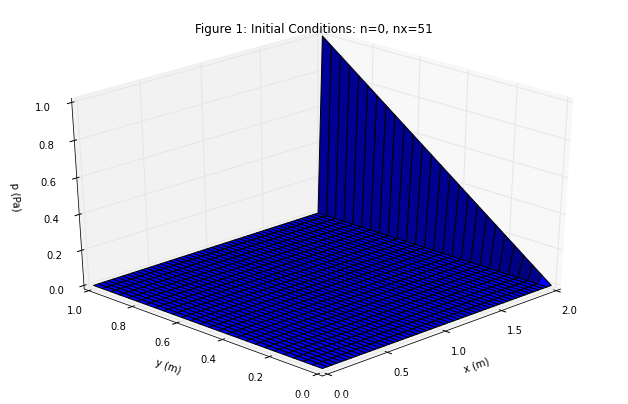

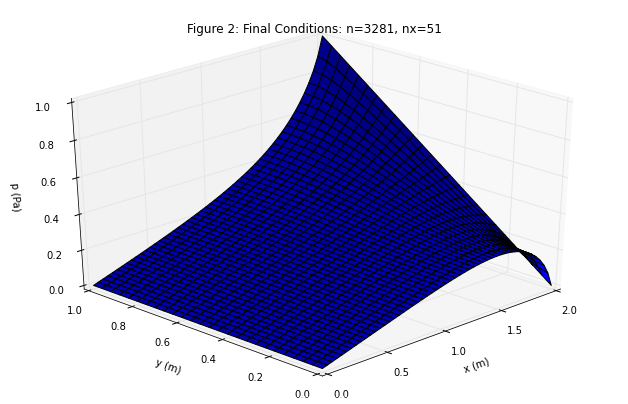

In [12]:
plot_3D(p1,x1,y1,0,'Figure 1: Initial Conditions: n=0, nx=51','p (Pa)')
plot_3D(p1,x1,y1,3129,'Figure 2: Final Conditions: n=3129, nx=51','p (Pa)')

## Now implement the solution to the Poisson Equation

In [25]:
def poisson_equation(error_target, niter, nx, xmax, ymax):

    """
    Returns the velocity field and distance for 2D Poisson Equation
    """
    # Increments in x and y are the same - h, dy & dx should be rational numbers:
    h = dy = dx = xmax/(nx-1)
    
    # Compute ny from dy and ymax - ny should be an integer
    ny = int(ymax/dy) + 1
    
    # Initialise data structures:
    import numpy as np
    p = np.zeros(((nx,ny,niter)))
    b = np.zeros((nx,ny))
    x = np.zeros(nx)
    y = np.zeros(ny)

    b[nx/4,ny/4] = 100
    b[3*nx/4,3*ny/4] = -100 
    
    # X Loop
    for i in range(0,nx):
      x[i] = i*dx

    # Y Loop
    for j in range(0,ny):
      y[j] = j*dy

    # Initial conditions
    p[:,:,0] = 0

    # Dirichlet Boundary Conditions:
    p[0,:,:] = p[nx-1,:,:] = p[:,0,:] = p[:,ny-1,:] = 0

    #Loop
    while True: 
      for n in range(0,niter-1):
        for i in range(1,nx-1):
          for j in range(1,ny-1): 
            p[i,j,n+1] = 0.25*( p[i+1,j,n]+p[i-1,j,n]+p[i,j+1,n]+p[i,j-1,n] - b[i,j]*h**2)
            
        error = (np.sum(np.abs(p[i,j,n+1])-np.abs(p[i,j,n]) ) / 
                    np.sum(np.abs(p[i,j,n+1]) ))
        
        if(error < error_target):
          print "n = " + str(n) + " completed"
          break
      break
            
    return p, x, y

In [41]:
p2, x2, y2 = poisson_equation(1.0e-6, 3000, 51, 2.0, 1.0)

n = 17 completed


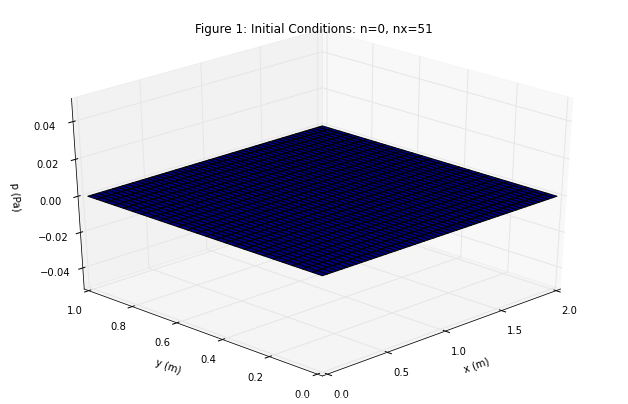

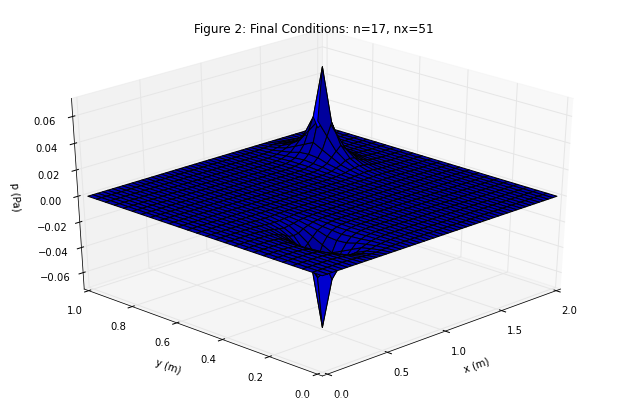

In [42]:
plot_3D(p2,x2,y2,0,'Figure 1: Initial Conditions: n=0, nx=51','p (Pa)')
plot_3D(p2,x2,y2,17,'Figure 2: Final Conditions: n=17, nx=51','p (Pa)')

## What is this?

* We have two sources (spikes) and the rest is the effect of diffusion
* Did run into trouble with memory in certain cases
* Seemed unstable at some points - but might have been a resolution problem?